In [123]:
from __future__ import print_function
import tensorflow as tf
from classification.models import model
from classification import metadata
import numpy as np
from datetime import datetime
import pytz
from classification import run_inference
import json
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class MyModel(model.ModelBase): 
    def build_inference_net(self):
        pass
    def build_training_net(self):
        pass
    @property
    def max_window_duration_seconds(self):
        # A fixed-length rather than fixed-duration window.
        return 0

    @property
    def window_max_points(self):
        return 1024
    
    def make_input_fn(self, base_feature_path, split, num_parallel_reads):
        def training_input_fn():
            return (fishing_feature_generation.input_fn(
                        self.vessel_metadata,
                        self.build_training_file_list(base_feature_path, split),
                        self.num_feature_dimensions + 1,
                        self.max_window_duration_seconds,
                        self.window_max_points,
                        self.min_viable_timeslice_length,
                        select_ranges=self.use_ranges_for_training,
                        num_parallel_reads=num_parallel_reads)
                .prefetch(self.batch_size)
                .batch(self.batch_size)
                )
        return training_input_fn
    
    def make_training_input_fn(self, base_feature_path, num_parallel_reads):
        return self.make_input_fn(base_feature_path, utility.TRAINING_SPLIT, num_parallel_reads)
    
root_feature_path = "gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features"
fishing_range_file = "classification/data/combined_fishing_ranges_vessel_id.csv"
metadata_file = "classification/data/training_classes_vessel_id.csv"

fishing_ranges = metadata.read_fishing_ranges(fishing_range_file)
all_available_mmsis = metadata.find_available_mmsis(root_feature_path)

vessel_metadata = MyModel.read_metadata(
        all_available_mmsis, metadata_file,
        fishing_ranges, 1)

# mdl = MyModel(14, vessel_metadata)
# files = mdl.build_training_file_list(root_feature_path , utility.TRAINING_SPLIT)

In [3]:
sorted(vessel_metadata.metadata_by_mmsi)[:10]

['000020b39-9a62-1a09-60fe-d65a9e39c2cf',
 '0000c5d13-3506-2b61-4e28-d6899b26042a',
 '0000e640f-f180-f001-2eec-7e35ff334468',
 '0000f9035-5cdc-333b-2a65-5cbb36b11e7e',
 '00012e8f4-4969-4ade-4c87-441dd4df3cb9',
 '0001caf0c-ccad-da52-51da-89a663aa557d',
 '0001d40eb-b6cd-6b77-df8d-abfb50da79ef',
 '00023cd36-6923-af32-1bef-62ccd5ae74f1',
 '000247f64-4b77-df37-ad93-f61ef44e72b3',
 '000257665-5945-b990-1011-bc453452ae78']

In [69]:
import imp
import pytz
import classification.models.objectives
imp.reload(classification.models.objectives)
from classification.feature_generation import vessel_feature_generation
imp.reload(vessel_feature_generation)
from classification.feature_generation import fishing_feature_generation
imp.reload(fishing_feature_generation)
import classification.models.vessel_characterization
imp.reload(classification.models.vessel_characterization)
import classification.models.vessel_characterization
imp.reload(classification.models.vessel_characterization)
from classification.models.vessel_characterization import Model
import classification.models.fishing_detection
import classification.feature_generation.feature_utilities
imp.reload(classification.feature_generation.feature_utilities)
from classification.feature_generation.feature_utilities import EPOCH_DT
# imp.reload(classification.models.prod.fishing_detection)
# from classification.models.prod.fishing_detection import Model

mdl = Model(14, vessel_metadata, 'minimal')
    
time_ranges = [(1328083200, 1343635200), (1343808000, 1359360000), (1359705600, 1375257600), (1375344000, 1390896000), (1391241600, 1406793600), (1406880000, 1422432000), (1422777600, 1438329600), (1438416000, 1453968000), (1454313600, 1469865600), (1470038400, 1485590400), (1485936000, 1501488000), (1501574400, 1517126400)]
# time_ranges = [((datetime(2015, 6, 1, tzinfo=pytz.utc) - EPOCH_DT).total_seconds(), (datetime(2015, 7, 1, tzinfo=pytz.utc) - EPOCH_DT).total_seconds())]
template = "gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/{}.tfrecord"
vessel_ids = vessel_metadata.metadata_by_mmsi.keys()[:10]
paths = [template.format(x) for x in vessel_ids]

# paths = """
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/000007c49-9673-3128-434d-6937d3400dd3.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/000008a58-83b9-f7c6-e3af-148f962497f4.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/000020b39-9a62-1a09-60fe-d65a9e39c2cf.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/000027eb4-4bec-76cc-062b-6ce5cdcac685.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/000073b65-58c6-abce-7fb1-a842a589aa96.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/0000747d7-71d7-a018-9e87-d0fbab2adac6.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/00009b2f0-0822-cdfc-ba1e-a4b05787f7b6.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/00009f31c-ca68-b94d-11cc-f47ebd7390b8.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/0000a8ba8-8c4c-255c-59e6-de6c90f79862.tfrecord
# gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features/0000b163b-b6ee-1b90-63d2-a2a1c6864e5a.tfrecord
# """.strip().split()

range_info = (datetime(2017,1,1), datetime(2017, 7, 1))
input_fn_p = mdl.make_prediction_input_fn(paths, time_ranges, 32)
iter_p = input_fn_p().make_one_shot_iterator()
el_p = iter_p.get_next()

input_fn_t = mdl.make_training_input_fn(root_feature_path, 32)
iter_t = input_fn_t().make_one_shot_iterator()
el_t = iter_t.get_next()

with tf.Session() as sess:
#     while True:
        x_p = sess.run(el_p)
        x_t = sess.run(el_t)
        print(x_p)
        print(x_t)


{'timestamps': array([[1448952064, 1448997760, 1449019776, ..., 1453312256, 1453313280,
        1453314176]], dtype=int32), 'mmsi': array(['-4484213255844134909'], dtype=object), 'features': array([[[10.730335  ,  6.601677  ,  0.41504836, ...,  0.        ,
          0.        ,  0.        ],
        [ 9.997342  ,  7.2467427 ,  0.7074879 , ...,  0.        ,
          0.        ,  0.        ],
        [ 8.23483   ,  6.0153675 ,  0.34469208, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 6.929517  ,  4.9091506 ,  0.41504836, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.8669333 ,  5.94337   ,  0.38048884, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.8679743 ,  6.0894523 ,  0.14352287, ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32), 'time_ranges': array([[1438416000, 1453968000]], dtype=int32)}
({'timestamps': array([[1446351104, 1446356608, 1446376832, ..., 1502705408, 1502707072,
        150270

In [70]:
x_p['features'].shape
print(x_p['features'].mean(axis=(0, 1)))
print(x_p['features'].std(axis=(0, 1)))

[ 6.6799445e+00  4.3288317e+00  4.1018948e-01  3.8333207e-01
  4.1953898e-03  4.1828036e-02 -2.6415611e-02  9.2504042e-01
  2.8000000e-01  1.3129959e-02  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[0.77054167 2.6774557  0.5551633  0.49860933 0.4567945  0.7275532
 0.68426394 0.06650381 0.24820158 0.5663661  0.         0.
 0.         0.        ]


In [71]:
print(x_t[0]['features'].mean(axis=(0, 1)))
print(x_t[0]['features'].std(axis=(0, 1)))

[ 6.8936419e+00  4.7072058e+00  6.7743248e-01  6.3935423e-01
 -9.3634496e-04 -3.3658214e-02 -1.2032776e-02 -1.4703342e-01
 -6.0603056e-02 -5.4457593e-03  1.9913859e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[1.0507505  3.3508055  0.7727394  0.7677102  0.33589932 0.714564
 0.6985328  0.7144175  0.68129355 0.5096354  2.0991254  0.
 0.         0.        ]


In [42]:
chkpt_path = 'gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization'
estimator = mdl.make_estimator(chkpt_path)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 300, '_keep_checkpoint_max': 10, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13c4d9910>, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_session_config': allow_soft_placement: true
, '_global_id_in_cluster': 0, '_is_chief': True, '_protocol': None, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_save_summary_steps': 20, '_model_dir': 'gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization', '_master': ''}


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 300, '_keep_checkpoint_max': 10, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13c4d9910>, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_session_config': allow_soft_placement: true
, '_global_id_in_cluster': 0, '_is_chief': True, '_protocol': None, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_save_summary_steps': 20, '_model_dir': 'gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization', '_master': ''}


In [124]:
for result in results:
    vid = vessel_metadata.mmsi_map_int2str[int(result['mmsi'])]
    cls = metadata.VESSEL_CLASS_DETAILED_NAMES[np.argmax(result['Vessel-class'])]
    print(vid[:5], 
          vessel_metadata.metadata_by_mmsi[vid][0]['label'], cls,
          vessel_metadata.metadata_by_mmsi[vid][0]['length'], np.exp(result['Vessel-length']))

TypeError: string indices must be integers, not str

In [86]:
# So running predictions "by hand" works. What about using an Inferer?

inferer = run_inference.Inferer(mdl, chkpt_path, root_feature_path)

all_results = []
for results in inferer.run_inference(vessel_ids, 6, datetime(2015,1,1, tzinfo=pytz.UTC), 
                                     datetime(2017, 12, 31, tzinfo=pytz.UTC)):
    all_results.append(results)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 300, '_keep_checkpoint_max': 10, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1642a7890>, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_session_config': allow_soft_placement: true
, '_global_id_in_cluster': 0, '_is_chief': True, '_protocol': None, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_save_summary_steps': 20, '_model_dir': 'gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization', '_master': ''}


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 300, '_keep_checkpoint_max': 10, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1642a7890>, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_session_config': allow_soft_placement: true
, '_global_id_in_cluster': 0, '_is_chief': True, '_protocol': None, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_save_summary_steps': 20, '_model_dir': 'gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization', '_master': ''}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization/model.ckpt-52007


INFO:tensorflow:Restoring parameters from gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization/model.ckpt-52007


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [87]:
for result in all_results:
    vid = vessel_metadata.mmsi_map_int2str[int(result['mmsi'])]
    cls = result['Multiclass']['max_label']
    print(vid[:5], 
          vessel_metadata.metadata_by_mmsi[vid][0]['label'], cls,
          vessel_metadata.metadata_by_mmsi[vid][0]['length'], result['length']['value'])

['engine_power', 'crew_size', 'mmsi', 'Multiclass', 'length', 'end_time', 'tonnage', 'start_time']
39f2a tug tug  35.01878387555168
39f2a tug tug  25.440610139345715
5346f fishing pots_and_traps 25.0 19.091515512773114
5346f fishing set_longlines 25.0 22.4011278726617
5346f fishing trawlers 25.0 24.637223308784705
b593e trawlers trawlers 25.91 22.530040846232584
b593e trawlers trawlers 25.91 27.923828980377685
b593e trawlers trawlers 25.91 30.172859986653037
b593e trawlers trawlers 25.91 21.613178030352763
b593e trawlers trawlers 25.91 18.772178521926453
b593e trawlers trawlers 25.91 24.444008754735272
13c5d patrol_vessel patrol_vessel  20.47387210663639
13c5d patrol_vessel passenger  16.525173923991215
13c5d patrol_vessel supply_vessel  17.972174510787653
13c5d patrol_vessel supply_vessel  17.977299982284517
5cd74 purse_seines|trawlers other_purse_seines 25.94 20.78642415754488
5cd74 purse_seines|trawlers other_purse_seines 25.94 20.532331490671844
5cd74 purse_seines|trawlers other_pu

In [110]:
cmd = r'''
docker-compose run vessel_inference  \
                --feature_path {}   \
                --checkpoint_path  {}    \
                --feature_dimensions 14   \
                --results_table=world-fishing-827:machine_learning_dev_ttl_120d.smoke_test_vessel_inference_v20181024_   \
                --start_date 2017-01-01   \
                --end_date 2017-12-31   \
                --project world-fishing-827   \
                --temp_location gs://machine-learning-dev-ttl-30d/scratch/inference   \
                --job_name smoke-test-vessel-inference   \
                --max_num_workers 100   \
                --setup_file ./setup.py   \
                --requirements_file requirements.txt   \
                --runner DataflowRunner  \
                --max_num_workers 100  \
                --worker_machine_type=custom-1-13312-ext
'''.format(root_feature_path, chkpt_path)
print(cmd)


docker-compose run vessel_inference  \
                --feature_path gs://machine-learning-dev-ttl-120d/features/ppb_features_through2017/features   \
                --checkpoint_path  gs://world-fishing-827-dev-ttl30d/data-production/classification/timothyhochberg/vessel_char_v20181023A/models/vessel_characterization    \
                --feature_dimensions 14   \
                --results_table=world-fishing-827:machine_learning_dev_ttl_120d.smoke_test_vessel_inference_v20181024_   \
                --start_date 2017-01-01   \
                --end_date 2017-12-31   \
                --project world-fishing-827   \
                --temp_location gs://machine-learning-dev-ttl-30d/scratch/inference   \
                --job_name smoke-test-vessel-inference   \
                --max_num_workers 100   \
                --setup_file ./setup.py   \
                --requirements_file requirements.txt   \
                --runner DataflowRunner  \
                --max_num_workers 100 

In [147]:
test_vessel_ids = vessel_metadata.metadata_by_split['Test'].keys()
np.random.seed(888)
test_vessel_ids = np.random.choice(test_vessel_ids, 2000)

query = """
SELECT * FROM `world-fishing-827.machine_learning_dev_ttl_120d.smoke_test_vessel_inference_v20181024_*` 
WHERE _TABLE_SUFFIX >= "20170101" AND
vessel_id  in ({})
LIMIT 1000
""".format(', '.join(['"{}"'.format(x) for x in test_vessel_ids]))



results_df = pandas.read_gbq(query, project_id='world-fishing-827', dialect='standard')

results_df.head()

,vessel_id,start_time,end_time,max_label,length,tonnage,engine_power,crew_size,label_scores
0,139fe09a6-6221-82dd-1f49-43349321b570,2017-01-01,2017-06-30,tug,25.485930,143.838393,1087.318508,15.439419,"[{u'score': 4.57e-08, u'label': u'bunker'}, {u..."
1,ebf3e1f82-2264-9756-cfd0-89637018c8b2,2017-01-01,2017-06-30,tug,38.439608,439.264651,4062.690956,6.570866,"[{u'score': 0.0, u'label': u'bunker'}, {u'scor..."
2,ba49c1ddd-d867-3037-e4b1-37bac0aa879e,2017-01-01,2017-06-30,tug,55.360821,917.048897,2549.575845,18.830699,"[{u'score': 5e-10, u'label': u'bunker'}, {u'sc..."
3,dfafe7f04-44f0-7d3e-ed2c-d456283f0d11,2017-01-01,2017-06-30,tug,20.391835,163.097074,1175.210340,19.928726,"[{u'score': 3.567e-07, u'label': u'bunker'}, {..."
4,5b1d463b8-823c-71ca-e314-cbd4b8efcf19,2017-01-01,2017-06-30,tug,34.295778,75.603018,700.753351,11.809607,"[{u'score': 0.0, u'label': u'bunker'}, {u'scor..."


In [148]:
for result in results_df.itertuples():
    vid = result.vessel_id
    cls = result.max_label
    print(vid[:5], 
          vessel_metadata.metadata_by_mmsi[vid][0]['label'], cls,
          vessel_metadata.metadata_by_mmsi[vid][0]['length'], result.length)

139fe cargo tug  25.4859295199
ebf3e tug tug  38.4396078609
ba49c tug tug  55.3608212881
dfafe tug tug  20.391834946
5b1d4 tug tug  34.2957780872
de03f tug tug 22.753 27.4971112472
f5572 tug tug  21.5942336656
f3e1d tug tug  25.3757555513
d30fc tug tug  24.0140294466
eba35 tug tug  18.4698531062
c6ac7 tug tug  29.4732177875
41adf tug tug 35.4105 61.3233613844
1f771 tug tug  23.0289172529
e409a tug tug  24.4536383514
fbfc2 tug tug 36.173 50.5865650163
69610 tug tug  22.100987728
44945 tug tug  51.5427429032
8b383 tug tug  29.0873020559
90705 tug tug  27.057425383
09553 cargo tug  28.1447305058
f79ae passenger tug  26.6631959942
9bba1 tug tug  40.7459890498
91fec tug tug  34.1963297297
90792 tug tug  20.5969479715
4e11e tanker tug  34.1118708665
1921b tug tug  35.8859248734
617df tug tug 21.471999999999998 23.3406462235
1c430 tug tug  16.8303896347
e80cb tug tug  23.2584483086
bf6f9 passenger tug  34.1494818671
9972c tug tug  17.8716799586
600e9 tug tug  38.9142219637
5ca2c tug tug  36.4

c7357 trawlers trawlers 20.84 16.6161278862
09f5a trawlers trawlers 19.58 22.1503791618
1c7e9 trawlers trawlers 95.18 70.6322149889
78056 trawlers trawlers 34.8 46.4700740469
4213f passenger passenger  54.2904085017
fffdb passenger passenger  86.6734177016
3d031 passenger passenger  19.5116623084
f568b research passenger  22.748421189
62338 passenger passenger  37.2474954138
63dbc passenger passenger  31.3768148803
3c502 passenger passenger  17.7515308609
75168 passenger passenger  42.8922054717
0cf47 passenger passenger  40.6540858661
e5539 cargo passenger  14.3386900697
8b672 passenger passenger  34.2744107199
2c913 passenger passenger  63.8593474086
c4d0b passenger passenger  64.1063817728
c0edb passenger passenger  16.6700771048
75a37 passenger passenger  18.7025417875
846b9 passenger passenger  81.2529616958
8cd3a passenger passenger  14.5530925349
5d214 passenger passenger  50.4222270501
c9c45 passenger passenger  45.1239198444
ee0a2 passenger passenger  42.2128793487
d8a53 passe

e070d cargo cargo  30.4957993898
44710 cargo cargo  39.8789348589
6a182 cargo cargo  149.4857685663


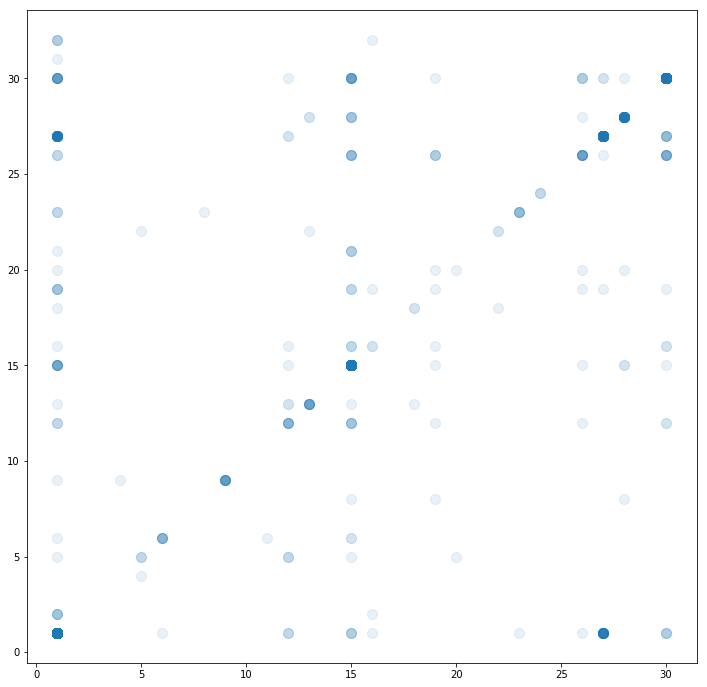

In [149]:
keys = [x['label'] for x in results_df.iloc[0].label_scores]
x = []
y = []
for result in results_df.itertuples():
    y.append(keys.index(result.max_label))
    vid = result.vessel_id
    lbl = vessel_metadata.metadata_by_mmsi[vid][0]['label']
    x.append(keys.index(lbl))
    
plt.figure(figsize=(12, 12))
plt.plot(x, y, '.', markersize=20, alpha = 0.1)
# keys

132

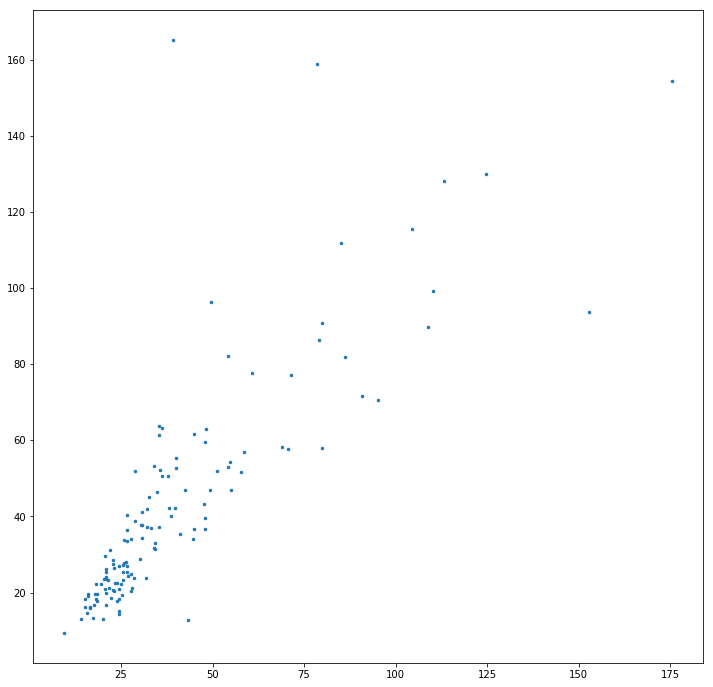

In [153]:
x = []
y = []
for result in results_df.itertuples():
    vid = result.vessel_id
    length = vessel_metadata.metadata_by_mmsi[vid][0]['length']
    if length:
        y.append((result.length))
        vid = result.vessel_id
        length = vessel_metadata.metadata_by_mmsi[vid][0]['length']
        x.append(length)
    
plt.figure(figsize=(12, 12))
plt.plot(x, y, '.', markersize=5)
len(x)

In [9]:
input_fn = mdl.make_test_input_fn(root_feature_path, 32, prefetch=1)
dataset = input_fn()
iter = dataset.make_one_shot_iterator()
el = iter.get_next()
with tf.Session() as sess:
    el = sess.run(el)

In [10]:
from classification.models.fishing_detection import Model
real_mdl = Model(14, vessel_metadata, 'minimal')

In [11]:
dataset = real_mdl.make_test_input_fn(root_feature_path, 4)()
iter = dataset.make_one_shot_iterator()
el = iter.get_next()
with tf.Session() as sess:
    el = sess.run(el)
el[0][0].shape, el[1].shape

((64, 1024, 14), (64, 1024))

In [12]:
import pandas as pd
train_df = pd.read_csv('classification/data/training_classes_vessel_id.csv')
train_df.head()

//anaconda/envs/ml2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,18,19,20,22,23,24,26,27,29,31,33,34,35,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,uvi,mmsi,shipname_matched,callsign_matched,flag,imo_matched,length,tonnage,engine_power,geartype_source,...,rev,reclsfy,chnsprfmo,carriers,chnfsh,isfishingvessel,issinglematch,label,split,_48
0,173873,2c399e624-4e75-5354-41f6-412dbb0bf7cf,LADYAMANDA,LW6379,ARG,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,unknown,Training,unknown
1,173873,f31c2de1d-d6e0-e169-7173-bbdf512434b3,LADYAMANDA,LW6379,ARG,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,unknown,Training,unknown
2,173865,1ed866964-4584-e6c4-5fe3-289b2f281fef,ELENADELTA,LW9438,ARG,NaN,NaN,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,unknown,Training,unknown
3,173865,f4f5cc7d8-84cf-823c-6e42-18cc45fe5af4,ELENADELTA,LW9438,ARG,NaN,NaN,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,unknown,Training,unknown
4,173722,731b77960-02d1-41bb-2651-46021d76cfb5,CODEPECA4,LW8189,ARG,NaN,NaN,339.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,unknown,Training,unknown


In [13]:
mmsis = open('mmsis.txt').read().strip().split()

IOError: [Errno 2] No such file or directory: 'mmsis.txt'

In [ ]:
in_both = set(mmsis) & set(train_df.mmsi)
len(in_both)

In [ ]:
sorted(mmsis)[:10]

In [ ]:
sorted(set(train_df.mmsi))[:10]

In [ ]:
mapper = pd.read_csv('train/ssvid_to_vessel_id.csv')

In [ ]:
sorted(set(mapper.vessel_id))[:10]

In [ ]:
def fakerator():
    while True:
        for i in range(3):
            yield i
        raise StopIteration
        
f = fakerator()

print('a')
for x in f:
    print x
    
print('b')
for x in f:
    print x

In [ ]:
2 + 2